# Decision Theory Application on Titanic

## Import of required modules and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
!pip install translate
from translate import Translator
print("Required libraries and modules imported successfully!")

import warnings
warnings.filterwarnings("ignore")
print("Warnings will be ignored")

Required libraries and modules imported successfully!
Warnings will be ignored


## Read Dataset

In [2]:
df = pd.read_csv("/content/titanic_preprocessed.csv")
print("Dataset imported!")

Dataset imported!


## Dimension of Dataset

In [3]:
print("Number of rows in the training set is : ", df.shape[0])
print("Number of columns in the training set is : ", df.shape[1])

Number of rows in the training set is :  891
Number of columns in the training set is :  13


## Columns

In the previous section, we found that the dataset has 13 columns. The names of the columns are shown in the following output.

In [4]:
pd.DataFrame(
    df.columns, 
    columns = ['Column Names'],
    index = range(1, len(df.columns)+1, 1)
)

,Column Names
1,PassengerId
2,Title
3,FirstName
4,LastName
5,Survived
6,Pclass
7,Sex
8,Age
9,SibSp
10,Parch


## Sample outlook on the dataset

In [5]:
df.sample(5)

,PassengerId,Title,FirstName,LastName,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
18,19,Mrs,Julius (Emelia Maria Vandemoortele),Vander Planke,0,3,female,31.000000,1,0,345763,4.50,S
252,253,Mr,William Thomas,Stead,0,1,male,62.000000,0,0,113514,26.55,S
656,657,Mr,Alexander,Radeff,0,3,male,31.184045,0,0,349223,7.90,S
615,616,Miss,Alice,Herman,1,2,female,24.000000,1,2,220845,4.06,S
52,53,Mrs,Henry Sleeper (Myna Haxtun),Harper,1,1,female,49.000000,1,0,PC 17572,19.18,C


## Data Pre-processing and Feature Engineering

### Removing Columns

The columns **PassengerId**, **FirstName**, **LastName** and **Ticket** will be removed as these columns have too much unique values.

In [6]:
df = df.drop(
        ["PassengerId", "FirstName", "LastName", "Ticket"],
        axis = 1
    )
print("Columns removed!")

Columns removed!


### Feature Engineering on "Title"

In [7]:
pd.DataFrame(
    index = [title for title in df["Title"].unique()],
    data = [(df["Title"][df["Title"] == title].count()) for title in df["Title"].unique()],
    columns = ["Count"]
)

,Count
Mr,517
Mrs,125
Miss,182
Master,40
Don,1
Rev,6
Dr,7
Mme,1
Ms,1
Major,2


It is clear from the above output, that the  count of the titles other than Mr, Mrs, Miss, Master are less than 10. 

Moreover, the titles "Mme" and "Mlle", respectively, stands for "Mrs" and "Mademoiselle" or "Miss".

In [8]:
translator = Translator(to_lang = "French")
translator.translate("Mme")

'Mrs'

In [9]:
translator = Translator(to_lang = "French")
translator.translate("Mlle")

'Mademoiselle'

So, "Mme" and "Mlle", respectively, will be replaced by, "Mrs" and "Miss".

"Ms" will also be replaced by "Miss".

The titles, "Don", "Rev", "Dr", "Major", "Lady", "Sir", "Col", "Capt", "the" and "Jonkheer" will be replaced by "Other_title".

In [10]:
replace_list = ["Don", "Rev", "Dr", "Mme", "Ms", "Major", "Lady", "Sir", "Mlle", "Col", "Capt", "the", "Jonkheer"]

for title in replace_list :
    if title == "Mme" :
        df["Title"].replace(
            {
                title : "Mrs"
            },
            inplace = True
        )
    elif (title == "Mlle") | (title == "Ms") :
        df["Title"].replace(
            {
                title : "Mrs"
            },
            inplace = True
        )
    else :
        df["Title"].replace(
            {
                title : "Other_title"
            },
            inplace = True
        )
print("Titles are changed")

Titles are changed


In [11]:
pd.DataFrame(
    index = [title for title in df["Title"].unique()],
    data = [(df["Title"][df["Title"] == title].count()) for title in df["Title"].unique()],
    columns = ["Count"]
)

,Count
Mr,517
Mrs,129
Miss,182
Master,40
Other_title,23


In [12]:
df["Title"].replace(
    {
        "Mr" : 0,
        "Mrs" : 1,
        "Miss" : 2,
        "Master" : 3,
        "Other_title" : 4
    },
    inplace = True
)

print("Titles Renamed!")

Titles Renamed!


### Categorizing "Age"

The Age is a continuous type of data. So we will categorize the column.

But before that, we need to look at the minimum and maximum values attained in the Age column.

In [13]:
print("Minimum Age : ", min(df["Age"]))
print("Maximum Age : ", max(df["Age"]))

Minimum Age :  0.42
Maximum Age :  80.0


We can categorize the age column as follows :

Range of Age | Categories | Denotions
:-----------:|:----------:|:---------:
0 - 5	     | Infant     | 0
5 - 12	     | Child      | 1
12 - 19	     | Teenager   | 2
19 - 35	     | Young Adult| 3
35 - 55	     | Middle Aged| 4
55 - 65	     | Adult      | 5
> 65	     | Senior     | 6

So, we will categorize the Age column in a new column named "Age Group" and then remove the "Age" column.

In [14]:
df["Age Group"] = pd.cut(
                    df["Age"],
                    bins = [0, 5, 12, 19, 35, 55, 65, 87],
                    right = True,
                    labels = [0, 1, 2, 3, 4, 5, 6]
                  )

df = df.drop(["Age"], axis = 1)

### Categorizing "Fare"

The Fare is a continuous type of data. So we will categorize the column.

But before that, we need to look at the minimum and maximum values attained in the Fare column.

In [15]:
print("Minimum Fare : ", min(df["Fare"]))
print("Maximum Fare : ", max(df["Fare"]))

Minimum Fare :  0.16
Maximum Fare :  512.33


As the range of the fares is high, so this column will be categorized using deciles. Then the "Fare" column will be removed.

In [16]:
df["Fare Group"] = pd.qcut(
                    df["Fare"],
                    q = 10,
                    labels = False
                  )

df = df.drop(["Fare"], axis = 1)

### Rename Categories in "Sex" and "Embarked"

#### Sex

In [17]:
df["Sex"].replace(
    {
        "male" : 0,
        "female" : 1
    },
    inplace = True
)

#### Embarked

In [18]:
df["Embarked"].replace(
    {
        "C" : 0,
        "Q" : 1,
        "S" : 2
    },
    inplace = True
)

## Sample outlook on the dataset after Pre-processing

In [19]:
df.sample(15)

,Title,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age Group,Fare Group
302,0,0,3,0,0,0,2,2,4
18,1,0,3,1,1,0,2,3,2
401,0,0,3,0,0,0,2,3,5
225,0,0,3,0,0,0,2,3,6
84,2,1,2,1,0,0,2,2,6
550,0,1,1,0,0,2,0,2,6
392,0,0,3,0,2,0,2,3,0
337,2,1,1,1,0,0,0,4,9
342,0,0,2,0,0,0,2,3,6
445,3,1,1,0,0,2,2,0,6


## Splitting of Dependent-Independent Columns

In [20]:
X = df.loc[ : , df.columns != 'Survived']
y = df['Survived']

## Train - Test Splitting

We will have 80% training data and 20% testing data.

In [21]:
X_train, X_test, y_train , y_test = train_test_split( 
                                        X, 
                                        y, 
                                        test_size = 0.2, 
                                        random_state = 7
                                    )

## Modelling

### CART

#### Training

Creating the classifier

In [22]:
cart = DecisionTreeClassifier( criterion = "gini" )

Fitting the classifier

In [23]:
cart.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### Testing

Making Predictions

In [24]:
y_train_pred_cart = cart.predict(X_train)
y_test_pred_cart = cart.predict(X_test)
print("Prediction done!")

Prediction done!


Checking Accuracy

In [25]:
train_accuracy_cart = accuracy_score(y_train, y_train_pred_cart)
test_accuracy_cart = accuracy_score(y_test, y_test_pred_cart)

pd.DataFrame(
    data = [train_accuracy_cart, test_accuracy_cart],
    columns = ["Accuracy Score"],
    index = ["Training Set", "Testing Set"]
)

,Accuracy Score
Training Set,0.912921
Testing Set,0.759777


#### Feature Importances

In [26]:
feature_importances = pd.DataFrame(
                            cart.feature_importances_,
                            index = X.columns,
                            columns=['importance']
                        )
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
Sex,0.447036
Age Group,0.120142
Pclass,0.112515
SibSp,0.095831
Fare Group,0.094486
Title,0.053460
Parch,0.038457
Embarked,0.038073


### ID3

#### Training

Creating the classifier

In [27]:
id3 = DecisionTreeClassifier( criterion = "entropy" )

Fitting the classifier

In [28]:
id3.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### Testing

Making Predictions

In [29]:
y_train_pred_id3 = id3.predict(X_train)
y_test_pred_id3 = id3.predict(X_test)
print("Prediction done!")

Prediction done!


Checking Accuracy

In [30]:
train_accuracy_id3 = accuracy_score(y_train, y_train_pred_id3)
test_accuracy_id3 = accuracy_score(y_test, y_test_pred_id3)

pd.DataFrame(
    data = [train_accuracy_id3, test_accuracy_id3],
    columns = ["Accuracy Score"],
    index = ["Training Set", "Testing Set"]
)

,Accuracy Score
Training Set,0.912921
Testing Set,0.737430


#### Feature Importances

In [31]:
feature_importances = pd.DataFrame(
                            id3.feature_importances_,
                            index = X.columns,
                            columns=['importance']
                        )
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
Title,0.457267
Fare Group,0.128510
Age Group,0.116863
Pclass,0.101386
SibSp,0.087958
Parch,0.054032
Embarked,0.053984
Sex,0.000000


### Grid Search

#### Finding best Tree

Setting up the parameters

In [32]:
parameters = {
                "criterion" : ["gini", "entropy"],
                "max_depth" : range(2,22,2),
                "min_samples_split" : range(2,22,2),
                "min_samples_leaf" : range(2,22,2),
                "max_features" : range(1,9,1),
                "class_weight" : ["balanced"]
            }

Creating the Classifier with GridSearchCV

In [33]:
grid_obj = GridSearchCV(
                DecisionTreeClassifier(), 
                param_grid = parameters, 
                scoring = make_scorer(accuracy_score),
                n_jobs = -1,
                verbose = 4
            )

Fitting the Grid

In [34]:
grid_fit = grid_obj.fit(X_train, y_train)

Fitting 5 folds for each of 16000 candidates, totalling 80000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1098 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 3066 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 5802 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 9338 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 13642 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 18746 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 24618 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 31290 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 38730 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 46970 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 55978 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 65786 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 76362 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 80000 

Finding the parameters of the best tree

In [35]:
grid_fit.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 4,
 'min_samples_leaf': 12,
 'min_samples_split': 2}

So the best tree uses "entropy" as criterion, i.e, the best tree is an ID3 tree.

#### Training

Creating the classifier

In [36]:
grid_best = grid_fit.best_estimator_

Fitting the best tree

In [37]:
grid_best.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=20, max_features=4,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=12,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

#### Testing

Making Predictions

In [38]:
y_train_pred_grid_best = grid_best.predict(X_train)
y_test_pred_grid_best = grid_best.predict(X_test)
print("Prediction done!")

Prediction done!


Checking Accuracy

In [39]:
train_accuracy_grid_best = accuracy_score(y_train, y_train_pred_grid_best)
test_accuracy_grid_best = accuracy_score(y_test, y_test_pred_grid_best)

pd.DataFrame(
    data = [train_accuracy_grid_best, test_accuracy_grid_best],
    columns = ["Accuracy Score"],
    index = ["Training Set", "Testing Set"]
)

,Accuracy Score
Training Set,0.827247
Testing Set,0.731844


#### Tree

[Text(1952.9999999999998, 3632.2363636363634, 'Pclass <= 2.5\nentropy = 1.0\nsamples = 100.0%\nvalue = [0.5, 0.5]\nclass = Survived'),
 Text(875.4827586206895, 3286.3090909090906, 'Age Group <= 1.5\nentropy = 0.93\nsamples = 45.6%\nvalue = [0.35, 0.65]\nclass = Survived'),
 Text(740.7931034482758, 2940.381818181818, 'entropy = 0.0\nsamples = 2.5%\nvalue = [0.0, 1.0]\nclass = Survived'),
 Text(1010.1724137931034, 2940.381818181818, 'Title <= 0.5\nentropy = 0.95\nsamples = 43.1%\nvalue = [0.38, 0.62]\nclass = Survived'),
 Text(538.7586206896551, 2594.454545454545, 'Fare Group <= 6.5\nentropy = 0.87\nsamples = 22.8%\nvalue = [0.71, 0.29]\nclass = Died'),
 Text(269.37931034482756, 2248.5272727272722, 'Age Group <= 3.5\nentropy = 0.7\nsamples = 11.0%\nvalue = [0.81, 0.19]\nclass = Died'),
 Text(134.68965517241378, 1902.5999999999997, 'entropy = 0.65\nsamples = 7.6%\nvalue = [0.83, 0.17]\nclass = Died'),
 Text(404.06896551724134, 1902.5999999999997, 'entropy = 0.8\nsamples = 3.4%\nvalue = [0

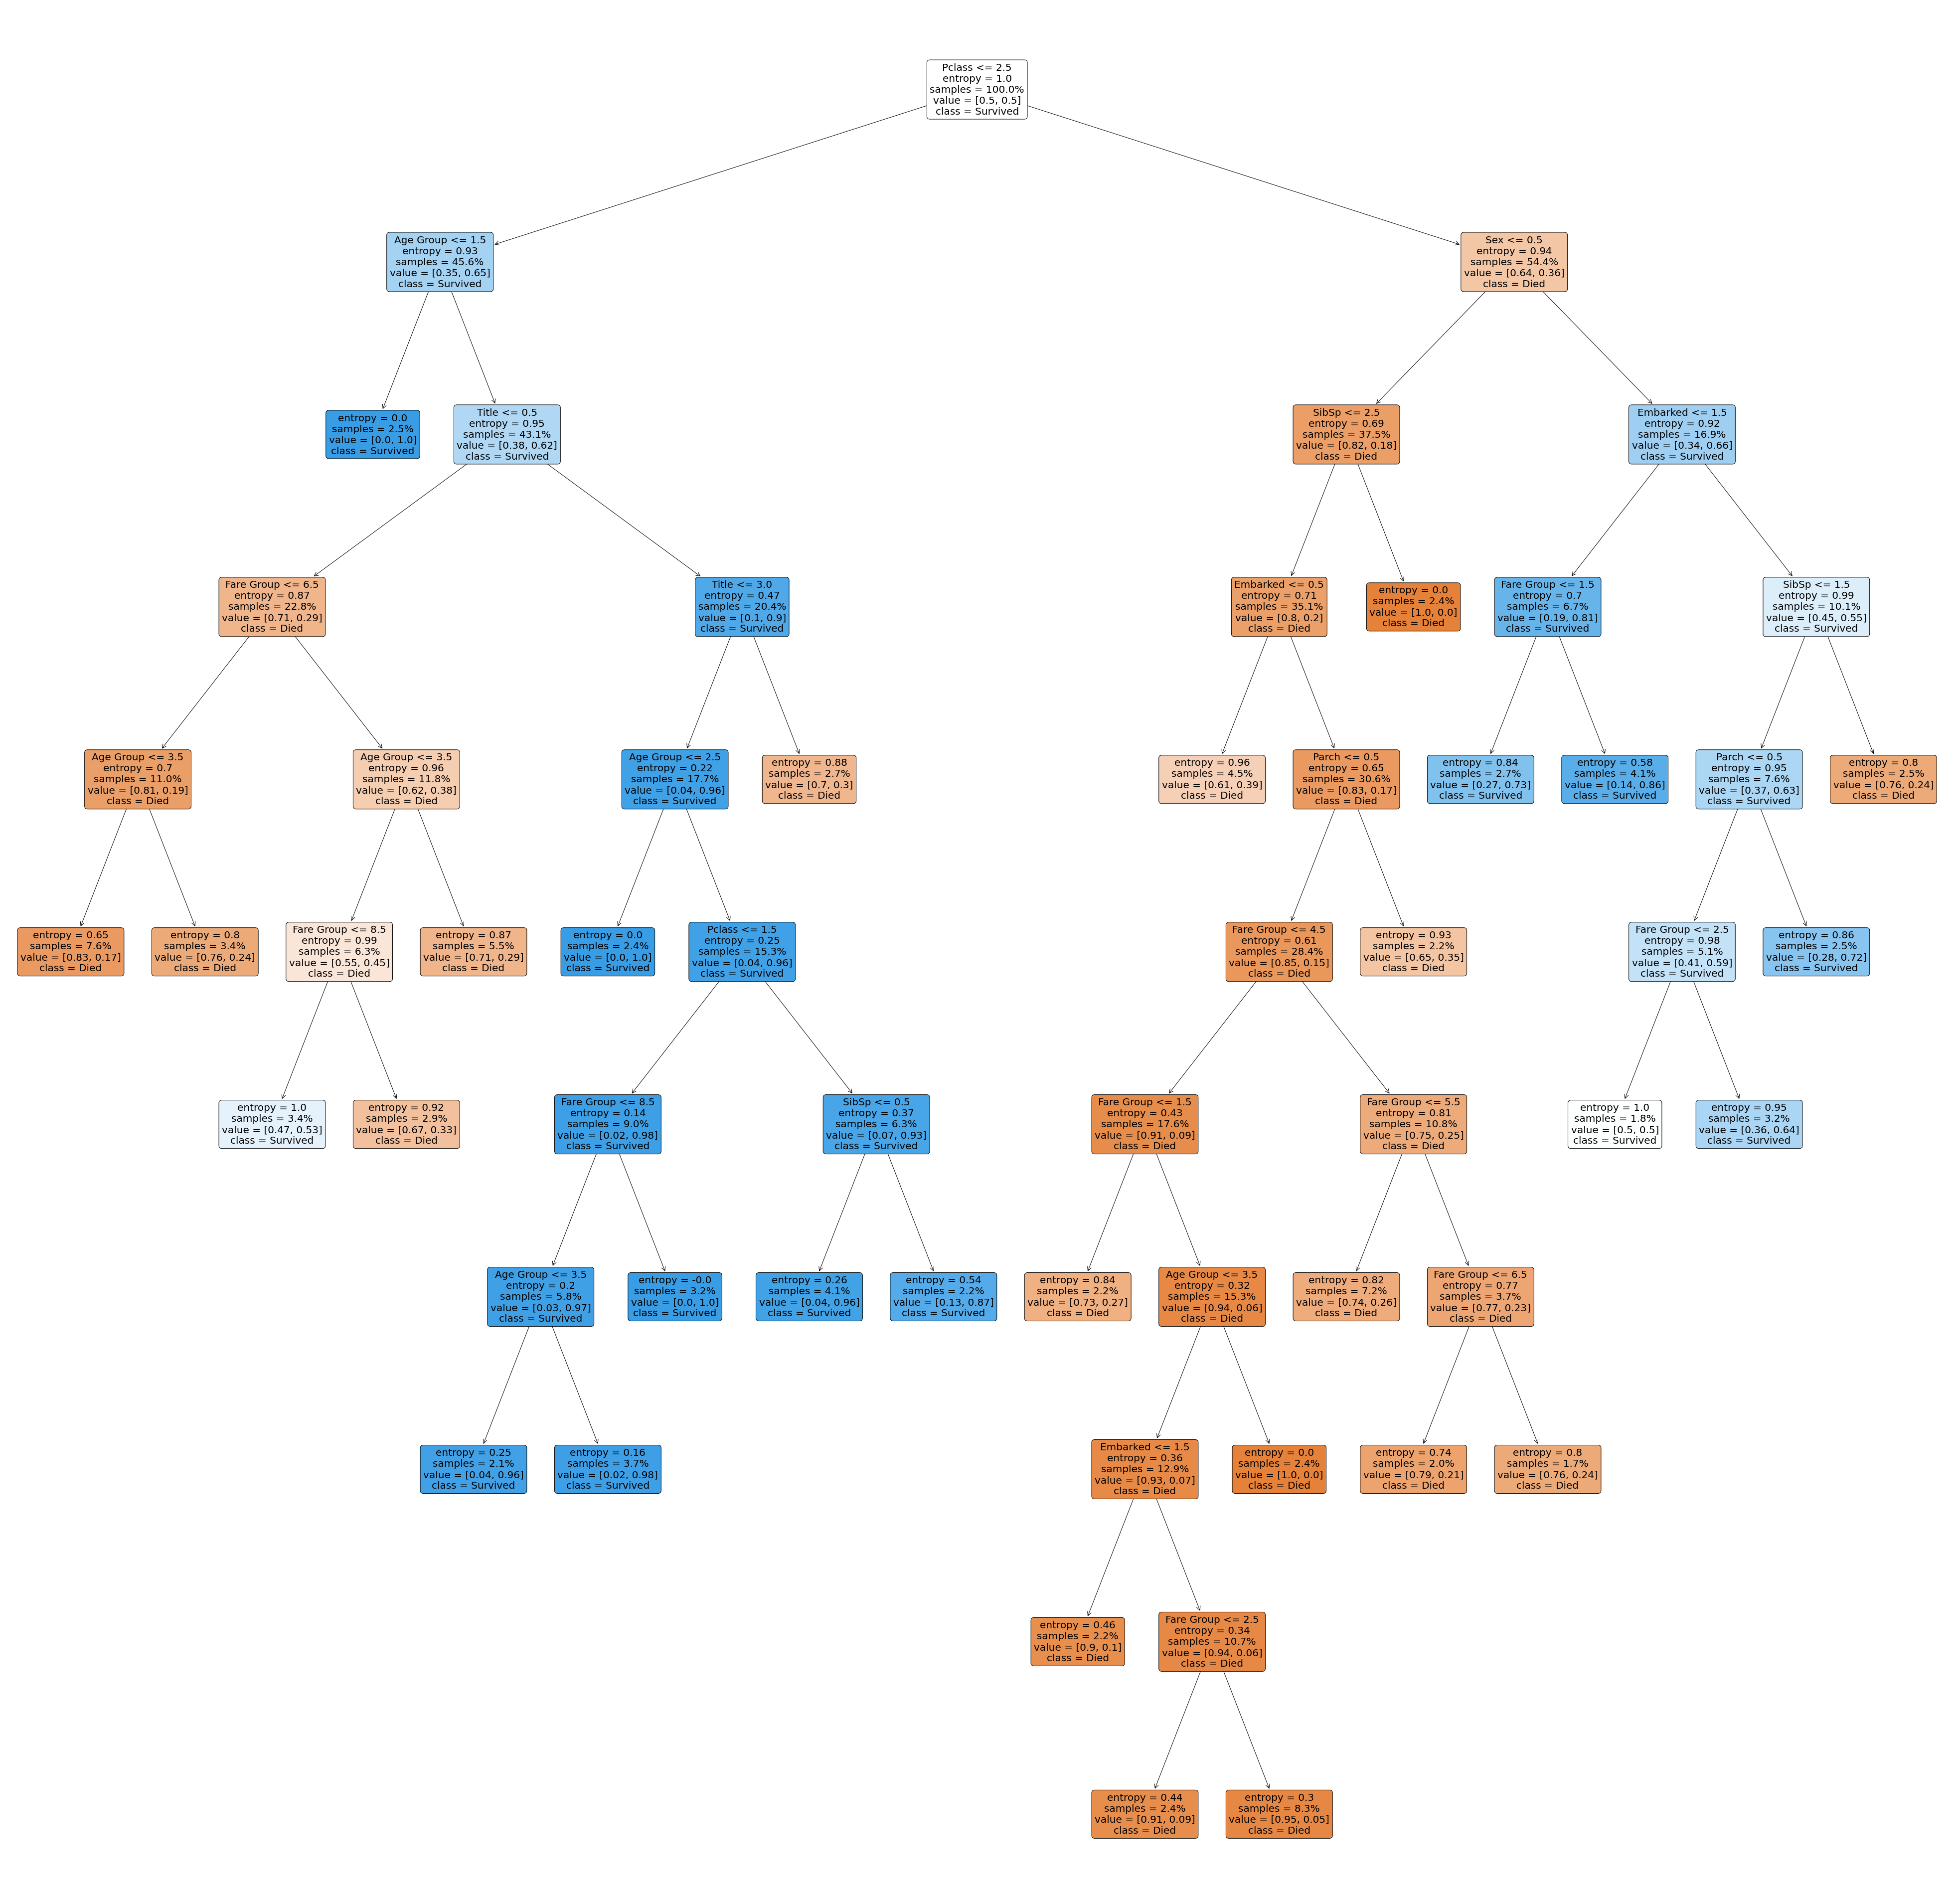

In [40]:
plt.figure(figsize=(70,70))
tree.plot_tree(
    grid_best,
    feature_names = X_train.columns,
    class_names = ["Died", "Survived"],
    filled = True,
    proportion = True,
    rounded = True,
    precision = 2,
    fontsize=20
)

#### Feature Importances

In [41]:
feature_importances = pd.DataFrame(
                            grid_best.feature_importances_,
                            index = X.columns,
                            columns=['importance']
                        )
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
Title,0.435523
Sex,0.198507
Pclass,0.153694
Age Group,0.064985
Fare Group,0.060106
Embarked,0.041661
SibSp,0.035587
Parch,0.009936


### Comparing the trees

In [42]:
pd.DataFrame(
    data = {
                "Accuracy on Training Set" : [train_accuracy_cart, 
                                              train_accuracy_id3, 
                                              train_accuracy_grid_best],
                "Accuracy on Testing Set" : [test_accuracy_cart, 
                                              test_accuracy_id3, 
                                              test_accuracy_grid_best],
            },
    index = ["CART", "ID3", "Grid Search"]
)

,Accuracy on Training Set,Accuracy on Testing Set
CART,0.912921,0.759777
ID3,0.912921,0.737430
Grid Search,0.827247,0.731844
